In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn import Sequential, Module
from matplotlib import pyplot as plt
import torch.optim as optim
import seaborn as sns
import random as rand

sns.set()

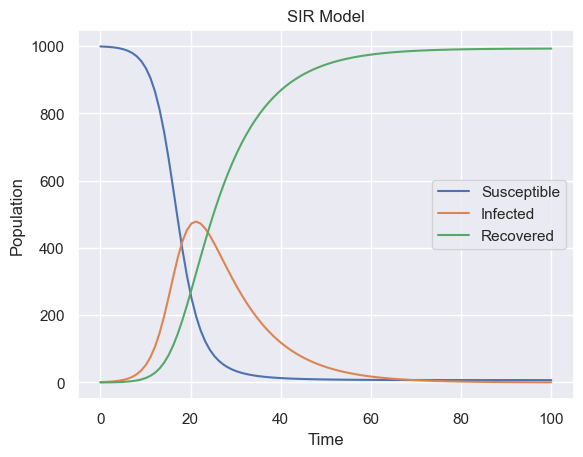

In [2]:
def generate_sir_curves(beta, gamma, population):
    def sir_model(y, t, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / population
        dIdt = beta * S * I / population - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    initial_conditions = [population - 1, 1, 0]  # Initial values for S, I, R
    t = np.linspace(0, 100, 100)  # Time points to evaluate the solution

    # Solve the SIR model
    solution = odeint(sir_model, initial_conditions, t, args=(beta, gamma))
    S, I, R = solution[:, 0], solution[:, 1], solution[:, 2]

    return t, S, I, R

# Parameters for the SIR model
beta = 0.5  # Infection rate
gamma = 0.1  # Recovery rate
population = 1000  # Total population

# Generate the SIR curves
t, S, I, R = generate_sir_curves(beta, gamma, population)

# Plot the curves
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model')
plt.legend()
plt.show()

## Training PINN To Fit SIR Model

Epoch 0, Loss 1.247458815574646, Val Loss 0.7088989615440369
Epoch 100, Loss 0.5051521062850952, Val Loss 0.21256676316261292
Epoch 200, Loss 0.30990296602249146, Val Loss 0.17608334124088287
Epoch 300, Loss 0.1835348755121231, Val Loss 0.1455015391111374
Epoch 400, Loss 0.10328421741724014, Val Loss 0.11005199700593948
Epoch 500, Loss 0.055649254471063614, Val Loss 0.04357219859957695
Epoch 600, Loss 0.028935760259628296, Val Loss 0.009288763627409935
Epoch 700, Loss 0.01526670902967453, Val Loss 0.001207046560011804
Epoch 800, Loss 0.009291567839682102, Val Loss 0.007170333992689848
Epoch 900, Loss 0.006362884305417538, Val Loss 0.0017777655739337206
Epoch 1000, Loss 0.005183043424040079, Val Loss 0.001684349961578846
Epoch 1100, Loss 0.005017206072807312, Val Loss 0.0021277088671922684
Epoch 1200, Loss 0.004711238667368889, Val Loss 0.002381943166255951
Epoch 1300, Loss 0.004645563196390867, Val Loss 0.0015198922483250499
Epoch 1400, Loss 0.004587644245475531, Val Loss 0.00130936806

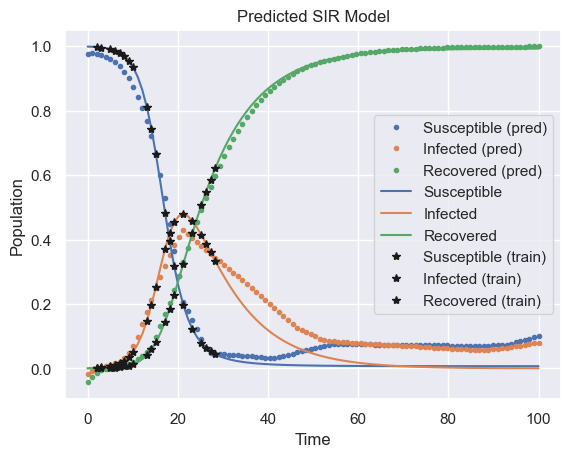

In [13]:
class simple_net(nn.Module):
    def __init__(self):
        super(simple_net, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, 3)

        # Model parameters
        self.beta = nn.Parameter(data=torch.tensor([0.]))
        self.gamma = nn.Parameter(data=torch.tensor([0.]))
        self.population = 1000

        # Best model
        self.best_loss = float('inf')
        self.best_model = None

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        x = torch.tanh(x)
        return x
    
    def grad(self, outputs, inputs):
        """Computes the partial derivative of
        an output with respect to an input."""
        return torch.autograd.grad(
            outputs,
            inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True
        )
    
    def physics_loss(self, weight=1):
        ts = torch.linspace(0, 100, steps=100,).view(-1,1).requires_grad_(True)
        SIR = self(ts)
        S, I, R = SIR[:,0], SIR[:,1], SIR[:,2]
        dS_dt = self.grad(S, ts)[0]
        dI_dt = self.grad(I, ts)[0]
        dR_dt = self.grad(R, ts)[0]

        loss_pop = torch.mean(((S + I + R - self.population)/self.population)**2)
        loss_S = torch.mean((dS_dt + self.beta * S * I / self.population)**2)
        loss_I = torch.mean((dI_dt - self.beta * S * I / self.population - self.gamma * I)**2)
        loss_R = torch.mean((dR_dt - self.gamma * I)**2)
        loss_params = torch.mean((self.beta - 0.5)**2 + (self.gamma-0.1)**2)

        return weight * (loss_S + loss_I + loss_R + loss_params)
        
    def train_model(model, X, y, X_val, y_val, epochs=1000, lr=0.001):
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y) + model.physics_loss(weight=3)
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                with torch.no_grad():
                    val_outputs = model(X_val)
                    val_loss = criterion(val_outputs, y_val)
                    scheduler.step(val_loss)
                    print(f'Epoch {epoch}, Loss {loss.item()}, Val Loss {val_loss.item()}')
                    if val_loss < model.best_loss:
                        model.best_loss = val_loss
                        model.best_model = model.state_dict()

        return model
    
    def predict(model, X):
        # Load the best model
        model.load_state_dict(model.best_model)
        model.eval()
        print(model.beta, model.gamma)
        return model(X)
        
# Generate the SIR curves
t, S, I, R = generate_sir_curves(beta, gamma, population)

# Normalize the data
# t = t / max(t)
S = S / population
I = I / population
R = R / population

# Randomly sample data for the first 40 time points
train_interval = int(len(t) * 0.20)
indices = rand.sample(range(30), train_interval)
train_t = t[indices]
S_train = S[indices]
I_train = I[indices]
R_train = R[indices]

# Convert the data to PyTorch tensors
train_t_tensor = torch.tensor(train_t).float().view(-1, 1)
train_S_tensor = torch.tensor(S_train).float().view(-1, 1)
train_I_tensor = torch.tensor(I_train).float().view(-1, 1)
train_R_tensor = torch.tensor(R_train).float().view(-1, 1)

# Convert the data to PyTorch tensors
test_t_tensor = torch.tensor(t).float().view(-1, 1)
test_S_tensor = torch.tensor(S).float().view(-1, 1)
test_I_tensor = torch.tensor(I).float().view(-1, 1)
test_R_tensor = torch.tensor(R).float().view(-1, 1)

# Combine the data
X_train = train_t_tensor
y = torch.cat([train_S_tensor, train_I_tensor, train_R_tensor], dim=1)

X_test = test_t_tensor
y_test = torch.cat([test_S_tensor, test_I_tensor, test_R_tensor], dim=1)

# Train the model
model = simple_net()
model = simple_net.train_model(model, X_train, y, X_test, y_test, epochs=10000)

# Predict the SIR curves
y_pred = simple_net.predict(model, X_test).detach().numpy()
S_pred, I_pred, R_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

# Plot the predicted SIR curves
plt.plot(t, S_pred, 'b.', label='Susceptible (pred)')
plt.plot(t, I_pred, 'C1.', label='Infected (pred)')
plt.plot(t, R_pred, 'g.', label='Recovered (pred)')
# Plot datapoints
plt.plot(t, S, 'b-', label='Susceptible')
plt.plot(t, I, 'C1-', label='Infected')
plt.plot(t, R, 'g-', label='Recovered')
# Plot traiing points
plt.plot(train_t, S_train, 'k*', label='Susceptible (train)')
plt.plot(train_t, I_train, 'k*', label='Infected (train)')
plt.plot(train_t, R_train, 'k*', label='Recovered (train)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predicted SIR Model')
plt.legend()
plt.show()
